# Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [2]:
DIR = '/content/drive/My Drive/ml-mini-projects/black-friday'

# Framing of the Problem

## Challenge:

The following dataset contains information from stores on a Black Friday, which sometimes refer to the Thanksgiving Friday in the US. You are tasked to build a model to predict the purchase amount of customers against various products.

**Evaluation Metric:** RMSE <br>
**Top scorer score:** 2372.0034421821

**Notes:** <br>
This challenge and dataset was sourced from [Analytics Vidhya](https://datahack.analyticsvidhya.com/contest/black-friday/?utm_source=facebook.com&utm_medium=social)


**Approach:** Regression Problem

# Taking Quick Glances

In [3]:
df = pd.read_csv(os.path.join(DIR, 'train.csv'))

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


**Observations:**
* It has a total of 550, 068 entries with 12 columns
   * Not so many features. Let's not do feature selection first
* Data types
   * User_ID, Product_ID 
      * not sure if this will help; try dropping
   * Gender, City Category as strings
      * hot encode this
   * Age, Stay In Current City Years are unexpectedly written as strings
      * Label Encoding - try converting to int or float (check unique values to decide)
   * Occupation is int (so already label encoded)
      * This may be placed for a reason. Let's try using this before hot encoding
   * Marital Status is already in its correct form
   * Product Category 1 and 2 are ints and 3 are floats.
      * can we convert Product Category 3 as int too?
      * also let's try to use this(label encoded) before doing one-hot
   * Purchase
      * does this represent the actual or in thousands or what? (no info to verify this)
* Nulls
   * Product Category 2 and 3 have many nulls


1. Let's first deal with the nulls

In [5]:
pd.concat([pd.DataFrame(df.isna().sum(), columns=['count']),(pd.DataFrame((df.isna().sum()/df.shape[0])*100, columns=['percentage']))], axis=1)

,count,percentage
User_ID,0,0.000000
Product_ID,0,0.000000
Gender,0,0.000000
Age,0,0.000000
Occupation,0,0.000000
City_Category,0,0.000000
Stay_In_Current_City_Years,0,0.000000
Marital_Status,0,0.000000
Product_Category_1,0,0.000000
Product_Category_2,173638,31.566643


In [6]:
# what if we drop Product_Category_2 only? How will that affect Product Category 3?
df_dum = df.dropna(subset=['Product_Category_2'])
df_dum.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2                 0
Product_Category_3            209609
Purchase                           0
dtype: int64

**Possible approach for NaNs**
1. If we drop all the nulls,
   * we will only be left with 166,821 which is 30% of the original dataset.
2. If we drop only Product_Category_2, 
   * 173, 638 are deducted so it means, those that are null in Product_Category_2 are also null in Product_Category_3
3. Replace nulls with 0s
   * I'll be trying this approach

Further: We can also see the nature of these rows with null later, so we will know its impact on our work.

In [7]:
# let's put it to a new dataframe since we can try droppin
df1 = df.fillna(0)

In [8]:
df1.isna().sum() # sanity check

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
dtype: int64

In [9]:
df1.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


2. Are there duplicates? none.

In [10]:
# are there duplicates?
df1.duplicated().sum()

0

In [11]:
# numerical data
df1.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,6.735436,3.841941,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,6.215492,6.250712,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,0.000000,0.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,0.000000,0.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,5.000000,0.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,14.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


3. Convert Product_Category_3

In [12]:
# look on unique values per column and number of unique values
for col in list(df1.columns):
  print(col, df1[col].unique(), len(df1[col].unique()))

User_ID [1000001 1000002 1000003 ... 1004113 1005391 1001529] 5891
Product_ID ['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853'] 3631
Gender ['F' 'M'] 2
Age ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25'] 7
Occupation [10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6] 21
City_Category ['A' 'C' 'B'] 3
Stay_In_Current_City_Years ['2' '4+' '3' '1' '0'] 5
Marital_Status [0 1] 2
Product_Category_1 [ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19] 20
Product_Category_2 [ 0.  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.] 18
Product_Category_3 [ 0. 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.] 16
Purchase [ 8370 15200  1422 ...   135   123   613] 18105


Product_Category_2 and Product_Category_3 are actually integers. Let's convert them to integers

In [13]:
df1 = df1.astype({'Product_Category_2':'int64', 'Product_Category_3':'int64'})

In [14]:
df1.info() # sanity check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category_1          550068 non-null  int64 
 9   Product_Category_2          550068 non-null  int64 
 10  Product_Category_3          550068 non-null  int64 
 11  Purchase                    550068 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 50.4+ MB


Other attributes' data type won't be changed for visualization but will be changed for data prep for ML

# Visualize

## 1. Purchase

Most spending occurs in 1,000-15,000

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


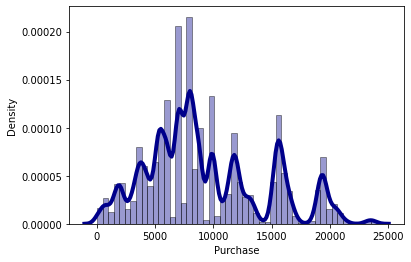

In [15]:
sns.distplot(df1['Purchase'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


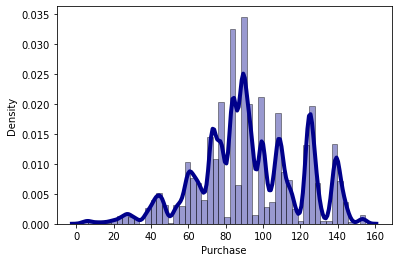

In [16]:
sns.distplot(np.sqrt(df1['Purchase']), hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


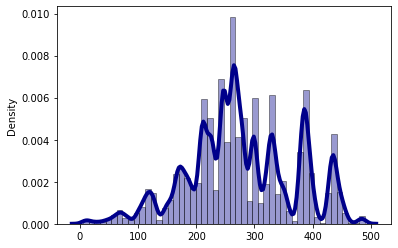

In [17]:
from scipy import stats

sns.distplot(stats.boxcox(df1['Purchase'])[0], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

## Spenders (User_Id)

1. Show top 5 spenders

In [65]:
top_spenders = df1.groupby('User_ID').sum()['Purchase'].sort_values(ascending=False)[:10]
top_spenders

User_ID
1004277    10536909
1001680     8699596
1002909     7577756
1001941     6817493
1000424     6573609
1004448     6566245
1005831     6512433
1001015     6511314
1003391     6477160
1001181     6387961
Name: Purchase, dtype: int64

2. Which products did they buy?

In [70]:
top_spenders = top_spenders.reset_index()['User_ID'].to_list()
top_spenders

[1004277,
 1001680,
 1002909,
 1001941,
 1000424,
 1004448,
 1005831,
 1001015,
 1003391,
 1001181]

In [85]:
top_spenders_profile = df1[df1['User_ID'].isin(top_spenders)].reset_index()
top_spenders_profile 

,index,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,2619,1000424,P00246142,M,26-35,17,A,3,0,1,15,17,15802
1,2620,1000424,P00352842,M,26-35,17,A,3,0,2,6,15,13014
2,2621,1000424,P00177142,M,26-35,17,A,3,0,8,13,0,9932
3,2622,1000424,P00350142,M,26-35,17,A,3,0,8,17,0,9739
4,2623,1000424,P00126142,M,26-35,17,A,3,0,8,16,0,9779
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7912,547057,1001680,P00372445,M,26-35,20,A,3,1,20,0,0,364
7913,547895,1002909,P00375436,M,26-35,7,A,1,0,20,0,0,251
7914,548209,1003391,P00375436,M,18-25,4,A,0,0,20,0,0,374
7915,548828,1004277,P00371644,M,36-45,16,A,0,0,20,0,0,126


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


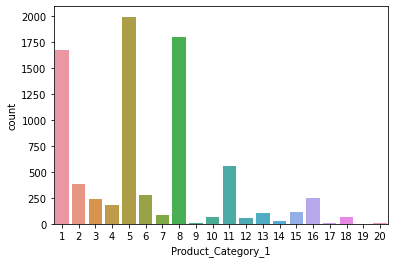

In [79]:
sns.countplot('Product_Category_1', data=top_spenders_profile)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


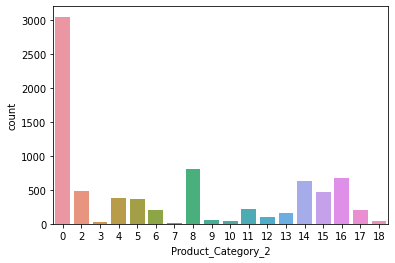

In [80]:
sns.countplot('Product_Category_2', data=top_spenders_profile)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


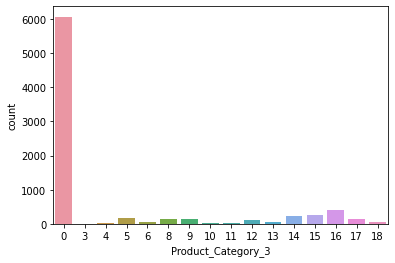

In [81]:
sns.countplot('Product_Category_3', data=top_spenders_profile)

3. Where are they from?

In [87]:
top_spenders_profile['City_Category'].unique()

array(['A'], dtype=object)

Is City Category A just an elite city? the top 10 spenders came from them.

4. What is the average spending per user?

In [91]:
df1.groupby('User_ID').sum()['Purchase'].mean()

865016.5917501273

5. Show the top 10 least spenders

In [93]:
least_spenders = df1.groupby('User_ID').sum()['Purchase'].sort_values(ascending=True)[:10]
least_spenders

User_ID
1004464    46681
1000094    49288
1003883    49349
1005117    49668
1004991    52371
1005944    53996
1002111    54536
1003291    55372
1003275    55960
1004636    57805
Name: Purchase, dtype: int64

In [94]:
least_spenders = least_spenders.reset_index()['User_ID'].to_list()
least_spenders

[1004464,
 1000094,
 1003883,
 1005117,
 1004991,
 1005944,
 1002111,
 1003291,
 1003275,
 1004636]

In [95]:
least_spenders_profile = df1[df1['User_ID'].isin(least_spenders)].reset_index()
least_spenders_profile 

,index,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,526,1000094,P00117042,M,26-35,17,C,1,0,1,2,5,15482
1,14297,1002111,P00226242,M,55+,13,C,4+,1,11,15,0,4663
2,20753,1003291,P00006142,F,26-35,7,B,4+,0,8,0,0,7946
3,30405,1004636,P00250242,M,18-25,2,B,2,1,5,0,0,7193
4,30406,1004636,P00158542,M,18-25,2,B,2,1,5,6,13,1899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,548134,1003275,P00370293,M,36-45,7,B,2,0,19,0,0,60
91,548146,1003291,P00370853,F,26-35,7,B,4+,0,19,0,0,25
92,548560,1003883,P00375436,M,51-55,16,C,2,1,20,0,0,245
93,548961,1004464,P00371644,F,51-55,1,C,1,0,20,0,0,590


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


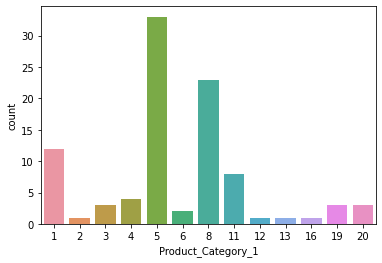

In [96]:
sns.countplot('Product_Category_1', data=least_spenders_profile)

In [97]:
least_spenders_profile['City_Category'].unique()

array(['C', 'B'], dtype=object)

### Gender

#### 1. Which gender have the most transactions?

75.31% of the transactions are men while only 24.69% transactions are female. 

In [18]:
((df1['Gender'] == 'M').sum()/df1.shape[0]) * 100

75.31050706458112

In [19]:
((df1['Gender'] == 'F').sum()/df1.shape[0]) * 100

24.689492935418894

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


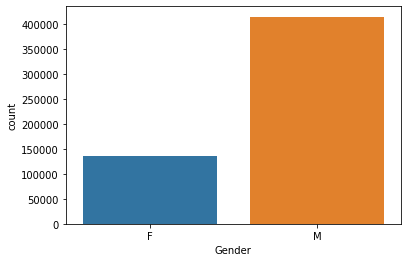

In [20]:
sns.countplot('Gender', data=df1)

#### 2. Which gender spends the most?

Males spend the most but the gap with females aren't that far anymore. 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


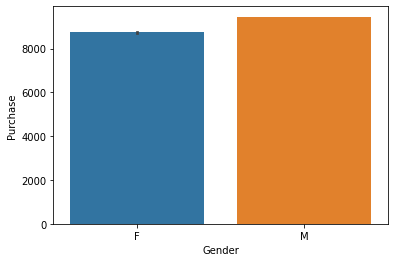

In [31]:
sns.barplot('Gender', 'Purchase', data=df1)

#### 3. Let's look further on the average spending per Gender

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


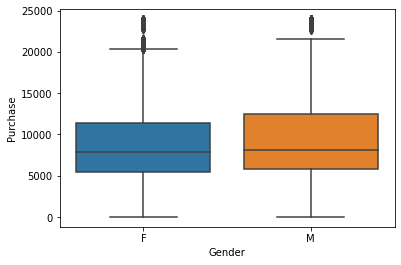

In [30]:
sns.boxplot('Gender', 'Purchase', data=df1)

In [26]:
print("Average Male Purchase:{:0.2f}".format(df1[df1['Gender']=='M']['Purchase'].mean()))

Average Male Purchase:9437.53


In [27]:
print("Average Female Purchase:{:0.2f}".format(df1[df1['Gender']=='F']['Purchase'].mean()))

Average Female Purchase:8734.57


## 